## Paper Reading Analysis - Code Implementation
### Model Data Partitioning , Model 1 Training, Hyperparameter Search and Evaluation
### Jonathan Alcineus

In [1]:
# These handle the file locations and importing the dataframe from the saved datafile from the authors files
import os
import pandas as pd


# These handle the image processing, editing, or displaying that needs to be performed
import cv2 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import skimage

# These handle training the convolutional neural network (CNN) model
import tensorflow as tf
import keras
import numpy as np
import sklearn
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD

import copy

2025-09-02 03:11:00.934292: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 03:11:03.232307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756782663.867621    3343 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756782664.078030    3343 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756782665.176218    3343 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:

# This changes the home directory
home_directory = os.path.expanduser("~")
os.chdir(home_directory)

# Then goes to the folder where the data lies
os.chdir('DNNorDermatologist')

# Ensures that we are in the correct folder
print(os.getcwd())

# Open the dataframe for the photos that are in the zip file
loaded_df = pd.read_pickle('NvAndMelNoDuplicatesFullSize.zip')


/teamspace/studios/this_studio/DNNorDermatologist


(450, 600, 3)

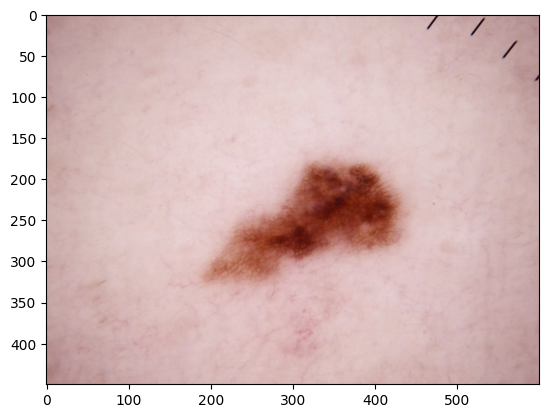

In [3]:
# Testing sizes, All the data is a uniform size
ind = 5000

plt.imshow(loaded_df.iloc[ind]['image'])
loaded_df.iloc[ind]['image'].shape

In [4]:
# This is to show the number of test images, classfying nevi vs the melanoma
# First number is the number of data that is in the dataset, second is the columns for the image and its respective label (nevi or melanoma)
loaded_df.shape

(5617, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.519258e-09..1.0].


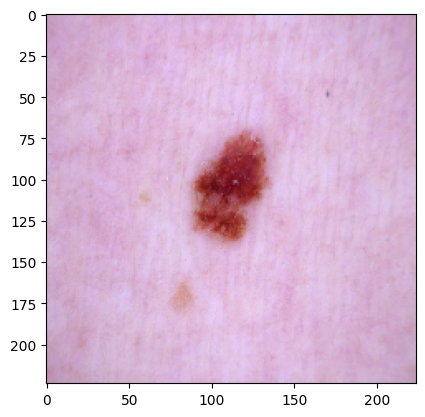

In [6]:
# Have to make another array to normalize all of the images by resizing them, this is where the edited will be stored
normalized_images = np.zeros((loaded_df.shape[0], 224, 224, 3), dtype='float32')

# Resizing the image matrices
for i in range(loaded_df.shape[0]):
  # Get original image as a numpy array (450, 600, 3)
  original_img = loaded_df.iloc[i]['image']
  
  # Resize to 224x224
  img_resized = cv2.resize(original_img, (224, 224))

  # Convert back to numpy and normalize pixel values
  img_normalized = cv2.normalize(img_resized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  normalized_images[i] = img_normalized


plt.imshow(normalized_images[0])

In [7]:
# Because there is significantly more nevi images compared to melanoma images, we need to augment that meloma images to match the size of the nevi images
# Using image transformations is the best way

# Get the corresponding labels from the dataframe as a np.array
labels_from_df = np.array(loaded_df['id'])

# Get all of the images that are melanoma from the dataframe
melanoma_imgs = normalized_images[np.where(labels_from_df=='mel')[0]]

# Here is the total number of melanoma images
print(len(melanoma_imgs))

414


In [8]:
# Building the augmented data to append to the entirety of the melanoma
augmented_data = []

# Do some image transformations to spice it up
for i in range(len(melanoma_imgs)):
    img = melanoma_imgs[i]
    aug_img = copy.deepcopy(img)

    # In model training, free for as much memory as you can
    del(img)

    # How to flip the image
    flip = np.random.choice(['horizontal', 'vertical', 'both'])

    if flip == 'horizontal':
        aug_img = cv2.flip(aug_img, 1)
    elif flip == 'vertical':
        aug_img = cv2.flip(aug_img, 0)
    elif flip == 'both':
        aug_img = cv2.flip(aug_img, -1)

    # Make sure to have all the values in the images to be between 0.0-1.0
    aug_img = np.clip(aug_img,0.0,1.0)
    
    # Add additional image augmentations
    gamma = np.random.uniform(0.5, 2.5)
    
    aug_img = skimage.exposure.adjust_gamma(aug_img, gamma, gain=1)

    augmented_data.append(aug_img)
    
    del(aug_img)

# Shows number of augmented data
augmented_data_len = len(augmented_data)

normalized_images = np.append(normalized_images, np.asarray(augmented_data), axis = 0)
del(augmented_data)

# Clears unused memory
import gc
gc.collect()
keras.backend.clear_session()


In [9]:
# Checking if the sizes match for the images and the ids
print(len(normalized_images))

for i in range(augmented_data_len):
   labels_from_df = np.append(labels_from_df, 'mel')

len(labels_from_df)

6031


6031

In [10]:
# Need to split the data into training and testing sets
# To get 30 models, we need 15 trials

n_trials = 15

# Converts to numpy array if the labels are not a numpy array
print(type(labels_from_df))

try:
    labels_from_df = labels_from_df.values
except:
    pass

# There is still not enough melanoma data for the model, instead, for each model
# 818 images of data for both melanoma and nevi will be spread through all of the models
# So we're creating datasplits

# Is the number of samples that I aim to get, rather than just learning from the majority
nsamples = labels_from_df[labels_from_df == 'mel'].shape[0] * 2

print("subsampling to", nsamples)


# Create our sub sample dataset
data_splits = {}
for i in range(n_trials):
    np.random.seed(i) # This will be used for reproducibility

    # Start with the ideas for encoding, so get the classes
    class0 = np.where(labels_from_df == "nv")[0]
    class1 = np.where(labels_from_df == "mel")[0]

    class0 = np.random.choice(class0, nsamples//2, replace=False)
    class1 = np.random.choice(class1, nsamples//2, replace=False)

    nsplit = int(nsamples//2 * 0.5) # 50% for training, the number of training items

    np.random.shuffle(class0)
    np.random.shuffle(class1)

    class0_train = class0[:nsplit]
    class0_test = class0[nsplit:]
    class1_train = class1[:nsplit]
    class1_test = class1[nsplit:]

    train_idxs = np.append(class0_train, class1_train)
    test_idxs = np.append(class0_test, class1_test)

    np.random.shuffle(train_idxs)
    np.random.shuffle(test_idxs)

    # Final training and testing sets for each of mini datasets
    X_train = normalized_images[train_idxs].astype(np.float32)
    y_train = labels_from_df[train_idxs]
    X_test = normalized_images[test_idxs].astype(np.float32)
    y_test = labels_from_df[test_idxs]

    y_train = [0 if item == 'nv' else 1 for item in y_train]
    y_test = [0 if item == 'nv' else 1 for item in y_test]

    data_splits[i] = [X_train, y_train, X_test, y_test]
    

    del X_train, y_train, X_test, y_test
    keras.backend.clear_session()
    gc.collect()
    


<class 'numpy.ndarray'>
subsampling to 1656


In [11]:
# For debugging
print(data_splits)

{0: [array([[[[0.6415117 , 0.5464665 , 0.5774801 ],
         [0.67451507, 0.57122344, 0.6349895 ],
         [0.6811937 , 0.5837635 , 0.64806   ],
         ...,
         [0.66123545, 0.56499374, 0.6811937 ],
         [0.6546347 , 0.5464665 , 0.6349895 ],
         [0.64806   , 0.540345  , 0.64806   ]],

        [[0.64806   , 0.5342507 , 0.60277414],
         [0.67451507, 0.5526152 , 0.60277414],
         [0.6811937 , 0.5774801 , 0.6349895 ],
         ...,
         [0.69462895, 0.5774801 , 0.70138526],
         [0.6546347 , 0.558791  , 0.66123545],
         [0.6415117 , 0.5221439 , 0.6284936 ]],

        [[0.66786224, 0.540345  , 0.6155809 ],
         [0.67451507, 0.5342507 , 0.62202406],
         [0.67451507, 0.5526152 , 0.6284936 ],
         ...,
         [0.69462895, 0.5774801 , 0.66123545],
         [0.66123545, 0.5464665 , 0.6284936 ],
         [0.6284936 , 0.5161316 , 0.60277414]],

        ...,

        [[0.12453828, 0.08915504, 0.11113555],
         [0.16442022, 0.11776175, 0.1421

In [12]:
# Save each of the small datasets in seperate numpy array files
# Save each trial's arrays separately
for i in range(len(data_splits)):
    np.save(f"paper_reading_small_data/trial_{i}_X_train.npy", data_splits[i][0])
    np.save(f"paper_reading_small_data/trial_{i}_y_train.npy", data_splits[i][1])
    np.save(f"paper_reading_small_data/trial_{i}_X_test.npy", data_splits[i][2])
    np.save(f"paper_reading_small_data/trial_{i}_y_test.npy", data_splits[i][3])


In [13]:
# Make sure to clear any of the data that is save into memory
del(data_splits)
keras.backend.clear_session()
gc.collect()

0

In [14]:
# Begin to build the classifier and the ranges for each model to find the optimal parameters, or searching through hyperparameters
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

space = [Real(1e-6, 0.01, "log-uniform", name='learning_rate'),
          Real(0.1, 0.8, name='dropout'),
          Real(0.8, 1.0, name='momentum'),
          Real(0.9, 1.0, name='beta_1'),
          Real(0.99, 1.0, name='beta_2'),
          Integer(low=5,high=20, name = 'epochs'),
          Integer(low=50, high=225, name='num_dense_nodes'),
          Categorical(categories=['SGD', 'Adam'],
                             name='optimizer_type')
          ]

In [15]:

# The first part to implenment is the creation of random models
if not os.path.isdir('suite_of_models'):
    os.mkdir('suite_of_models')

def make_a_model(learning_rate, dropout, momentum, beta_1, beta_2, num_dense_nodes, optimizer_type):
    # Like in the paper the base model for the image classifcation will be imagenet
    base_model = InceptionV3(weights='imagenet',input_shape=(224, 224, 3), include_top=False)

    # Fine tune the model with extra dense layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_dense_nodes, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(rate=dropout)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Selects a type of model optimizer
    if optimizer_type == "Adam":
        optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer_type == "SGD":
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(loss='binary_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy'])
    return model

In [16]:
# Start off with basic parameters and the batch size for the models
batch_size = 16
best_accuracy = {} 
for seed in range(n_trials):
  best_accuracy[seed] = 0.0

In [17]:
data_splits = np.load('paper_reading_small_data/trial_0_X_test.npy', allow_pickle=True)

print(data_splits)

[[[[0.2785388  0.07762557 0.08675799]
   [0.31963468 0.10045662 0.1324201 ]
   [0.32876712 0.1324201  0.1369863 ]
   ...
   [0.14155251 0.07305936 0.10502283]
   [0.11872146 0.08675799 0.10502283]
   [0.1324201  0.08219178 0.07762557]]

  [[0.2876712  0.0958904  0.12785387]
   [0.30593607 0.10958903 0.15981734]
   [0.33789954 0.1324201  0.14155251]
   ...
   [0.16438356 0.08675799 0.10958903]
   [0.14611872 0.08675799 0.10045662]
   [0.12328766 0.07305936 0.0913242 ]]

  [[0.30593607 0.0958904  0.14155251]
   [0.3242009  0.10045662 0.14611872]
   [0.369863   0.15981734 0.17351598]
   ...
   [0.1872146  0.08675799 0.10958903]
   [0.1324201  0.0958904  0.08219178]
   [0.1369863  0.08675799 0.10502283]]

  ...

  [[0.6484018  0.54337895 0.53424656]
   [0.6666666  0.5525114  0.54337895]
   [0.6940639  0.56164384 0.56621003]
   ...
   [0.5753424  0.46118718 0.46118718]
   [0.5525114  0.4155251  0.43835613]
   [0.5114155  0.38812783 0.38356164]]

  [[0.6666666  0.56164384 0.54337895]
   [0.6

In [18]:

# Training on seed 0 for this cell

seed = 0

print('We are currently training on seed:', seed) 
# for each iteration of the hyperparameter search, return a set of parameters
# and feed them into the relevant parts
# run training of the model for this seed, save with seed num
X_train = np.load(f'paper_reading_small_data/trial_{seed}_X_train.npy', allow_pickle=True)
y_train = np.load(f'paper_reading_small_data/trial_{seed}_y_train.npy', allow_pickle=True)
X_test = np.load(f'paper_reading_small_data/trial_{seed}_X_test.npy', allow_pickle=True)
y_test = np.load(f'paper_reading_small_data/trial_{seed}_y_test.npy', allow_pickle=True)

path_best_model = 'inception_saved_trial_{}.keras'.format(seed)
  
@use_named_args(dimensions=space)
def fitness(learning_rate, dropout, momentum, beta_1, beta_2,
              num_dense_nodes, optimizer_type, epochs):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_nodes:', num_dense_nodes)
    print('dropout:', dropout)
    print('optimizer_type:', optimizer_type)
    print('epochs:', epochs)

    # Create the neural network with these hyper-parameters.
    model = make_a_model(learning_rate=learning_rate, 
                         dropout=dropout, 
                         momentum=momentum, 
                         beta_1=beta_1, beta_2=beta_2,
                         num_dense_nodes=num_dense_nodes, 
                         optimizer_type=optimizer_type)

    # Use Keras to train the model.
    history = model.fit(x=X_train,
                          y=y_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data= (X_test,y_test))

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]
    # auc_val = history.history['val_auc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    if accuracy > best_accuracy[seed]:
      # Save the new model to harddisk in the recommended Keras format
      model_path = os.path.join('DataSplitted', path_best_model)
      model.save(model_path)
    

      # Update the classification accuracy.
      best_accuracy[seed] = accuracy
      # best_auc = auc_val
          

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    import gc

    keras.backend.clear_session()
    gc.collect()

    try:
      tf.config.experimental.reset_memory_stats("GPU:0")
    except:
      pass  # in case older TF version
    return -accuracy

  
#This conducts the hyperparameter search over each data split for details see: https://scikit-optimize.github.io/#skopt.gp_minimize
search_result = gp_minimize(func=fitness,
                            dimensions=space,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
			    n_random_starts = 5,
                            verbose = True)
print('Seed: ',seed)
print("BEST ACCURACY: ", best_accuracy)
print('hyper_params ', search_result.x)

del X_train, y_train, X_test, y_test 

import gc

keras.backend.clear_session()
gc.collect()

We are currently training on seed: 0


Iteration No: 1 started. Evaluating function at random point.
learning rate: 1.3e-06
num_dense_nodes: 98
dropout: 0.4191636884981206
optimizer_type: Adam
epochs: 10


I0000 00:00:1755969922.671860   63334 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1755969960.568014   74144 service.cc:152] XLA service 0x7fcf80003f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755969960.568305   74144 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-23 17:26:01.866481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755969967.658355   74144 cuda_dnn.cc:529] Loaded cuDNN version 91200
2025-08-23 17:26:17.671249: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-23 17:26:17.818726: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investiga

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1:04:10 76s/step - accuracy: 0.6250 - loss: 0.6598

I0000 00:00:1755970002.457376   74144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5446 - loss: 0.7174

2025-08-23 17:27:02.003937: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-23 17:27:02.149978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-23 17:27:02.495393: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-23 17:27:02.638219: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/52 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5411 - loss: 0.7116 - val_accuracy: 0.5483 - val_loss: 0.6968
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 52s 151ms/step - accuracy: 0.5773 - loss: 0.6830 - val_accuracy: 0.6220 - val_loss: 0.6580
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.6208 - loss: 0.6446 - val_accuracy: 0.6787 - val_loss: 0.6305
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.6739 - loss: 0.6158 - val_accuracy: 0.7089 - val_loss: 0.6044
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.6969 - loss: 0.5965 - val_accuracy: 0.7198 - val_loss: 0.5870
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.6763 - loss: 0.5981 - val_accuracy: 0.7319 - val_loss: 0.5711
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.7271 - loss: 0.5600 - val_accuracy: 0.7379 - val_loss: 0.5610
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.7077 - loss: 0.5629 - val_accuracy: 0.7500 - val_

0

All of the other 14 models have been trained in separate Jupyter notebooks. The format for each of the names of the notebook is 'model_{#}_training.ipynb'.